# Visualize MAP-Elites 🔎

## Import

In [1]:
import os
from pathlib import Path
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

from lenia.lenia import ConfigLenia, Lenia
from qdax.core.containers.mapelites_repertoire import MapElitesRepertoire

import matplotlib.pyplot as plt
import mediapy
from IPython.display import display, HTML
from omegaconf import OmegaConf
from analysis.visualize_me import plot_me_repertoire
from common import get_metric

ModuleNotFoundError: No module named 'lenia'

## Load run

In [32]:
run_dir = Path("output/me/pos_mass_var/2024-08-14_104736_845423")

In [33]:
# Get config
config = OmegaConf.load(run_dir / ".hydra" / "config.yaml")

# Init a random key
key = jax.random.PRNGKey(config.seed)

# Lenia
config_lenia = ConfigLenia(
	# Init pattern
	pattern_id=config.pattern_id,

	# Simulation
	world_size=config.world_size,
	world_scale=config.world_scale,
	n_step=config.n_step,

	# Genotype
	n_params_size=config.n_params_size,
	n_cells_size=config.n_cells_size,
)
lenia = Lenia(config_lenia)

# Lenia steps
lenia_step = partial(lenia.step, phenotype_size=config_lenia.world_size, center_phenotype=False, record_phenotype=True)
lenia_step_large = partial(lenia.step, phenotype_size=config.world_size, center_phenotype=True, record_phenotype=True)

# Load pattern
init_carry, init_genotype, other_asset = lenia.load_pattern(lenia.pattern)

## Load repertoire

In [34]:
_, reconstruction_fn = ravel_pytree(init_genotype)
repertoire = MapElitesRepertoire.load(reconstruction_fn=reconstruction_fn, path=str(run_dir) + "/repertoire/")

In [35]:
# Plot
if repertoire.centroids.shape[-1] == 2:
	fig, axes = plot_me_repertoire(config, repertoire)
	plt.show()
	plt.close()
else:
	pass

## Evaluate

In [6]:
def get_fitness(accum):
	fitness = get_metric(accum, config.qd.fitness, config.qd.n_keep)
	assert fitness.size == 1
	fitness = jnp.squeeze(fitness)
	failed = jnp.logical_or(accum.stats.is_empty.any(), accum.stats.is_full.any())
	fitness = jnp.where(failed, -jnp.inf, fitness)
	return fitness

def evaluate(genotype):
	carry = lenia.express_genotype(init_carry, genotype)
	carry, accum = jax.lax.scan(lenia_step, init=carry, xs=jnp.arange(lenia._config.n_step))
	return accum

def evaluate_large(genotype):
	carry = lenia.express_genotype(init_carry, genotype)
	carry, accum = jax.lax.scan(lenia_step_large, init=carry, xs=jnp.arange(lenia._config.n_step))
	return accum

## Best Solitons 🏆


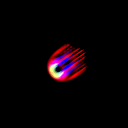
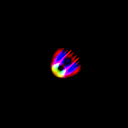
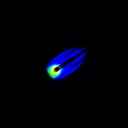
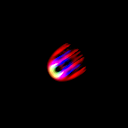
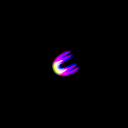
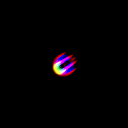
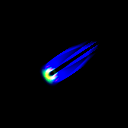
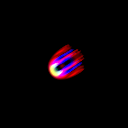
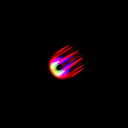
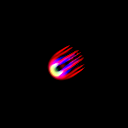

In [36]:
# Select genotypes
genotype_start = 10
indices = jnp.argsort(repertoire.fitnesses)[-1-genotype_start:-1-genotype_start-10:-1]
genotypes = repertoire.genotypes[indices]

# Evaluate
accum = jax.vmap(evaluate)(genotypes)
accum_large = jax.vmap(evaluate_large)(genotypes)

# Display
titles = [f"{index}" for index in indices]
html = mediapy.show_videos(accum.phenotype, titles=titles, width=128, height=128, fps=50, return_html=True)
html += mediapy.show_images(accum_large.phenotype[:, -1], width=128, height=128, return_html=True)

display(HTML(html))

## Random Solitons 🎲


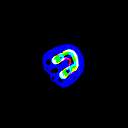
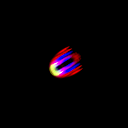
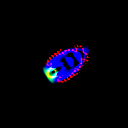
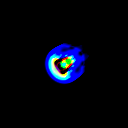
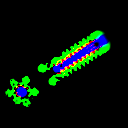
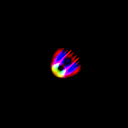
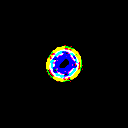
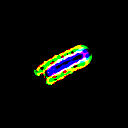
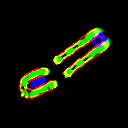
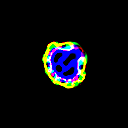

In [38]:
# Select genotypes
num_genotypes = 10
key, subkey = jax.random.split(key)
valid = repertoire.fitnesses != -jnp.inf
indices = jax.random.choice(subkey, jnp.arange(config.qd.repertoire_size), shape=(num_genotypes,), replace=False, p=valid)
genotypes = repertoire.genotypes[indices]

# Evaluate
accum = jax.vmap(evaluate)(genotypes)
accum_large = jax.vmap(evaluate_large)(genotypes)

# Display
titles = [f"{index}" for index in indices]
html = mediapy.show_videos(accum.phenotype, titles=titles, width=128, height=128, fps=50, return_html=True)
html += mediapy.show_images(accum_large.phenotype[:, -1], width=128, height=128, return_html=True)

display(HTML(html))

## Interpolation 🎚️

In [39]:
def get_closest_genotype_index(repertoire, descriptor):
	distances = jnp.linalg.norm(repertoire.descriptors - descriptor, axis=1)
	distances = jnp.where(repertoire.fitnesses == -jnp.inf, jnp.inf, distances)
	return jnp.argmin(distances)

def interpolate_genotypes(repertoire, descriptor_start, descriptor_end, num_genotypes):
    descriptors = jnp.linspace(descriptor_start, descriptor_end, num_genotypes)
    indices = jax.vmap(get_closest_genotype_index, in_axes=(None, 0))(repertoire, descriptors)
    return indices

### Locomotion 🏃


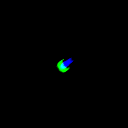
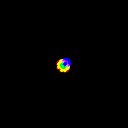
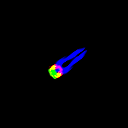
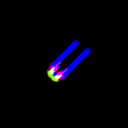
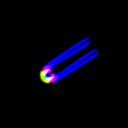
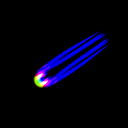
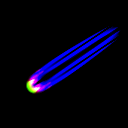
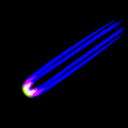
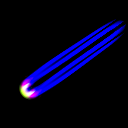
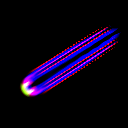

In [20]:
num_genotypes = 10
descriptor_start = jnp.array([0., 0.])
descriptor_end = jnp.array([16., 0.3])

indices = interpolate_genotypes(repertoire, descriptor_start, descriptor_end, num_genotypes=num_genotypes)
genotypes = repertoire.genotypes[indices]

# Evaluate
accum = jax.vmap(evaluate)(genotypes)
accum_large = jax.vmap(evaluate_large)(genotypes)

# Display
titles = [f"{index}" for index in indices]
html = mediapy.show_videos(accum.phenotype, titles=titles, width=128, height=128, fps=50, return_html=True)
html += mediapy.show_images(accum_large.phenotype[:, -1], width=128, height=128, return_html=True)

display(HTML(html))

### Colors 🎨


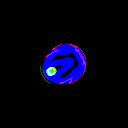
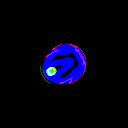
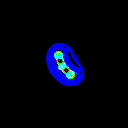
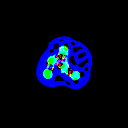
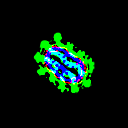
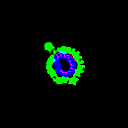
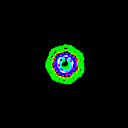
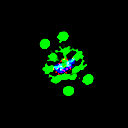
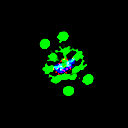
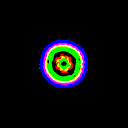

In [47]:
num_genotypes = 10
descriptor_start = jnp.array([0., 0., 1.])
descriptor_end = jnp.array([0., 1., 0.])

indices = interpolate_genotypes(repertoire, descriptor_start, descriptor_end, num_genotypes=num_genotypes)
genotypes = repertoire.genotypes[indices]

# Evaluate
accum = jax.vmap(evaluate)(genotypes)
accum_large = jax.vmap(evaluate_large)(genotypes)

# Display
titles = [f"{index}" for index in indices]
html = mediapy.show_videos(accum.phenotype, titles=titles, width=128, height=128, fps=50, return_html=True)
html += mediapy.show_images(accum_large.phenotype[:, -1], width=128, height=128, return_html=True)

display(HTML(html))